In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import openai
import pandas as pd
import re

In [2]:
# Set your OpenAI API key
openai.api_key = ''

In [3]:
# Function to get OpenAI embeddings for a list of texts (reviews)
def get_openai_embeddings(texts):
    response = openai.Embedding.create(
        model="text-embedding-ada-002",
        input=texts
    )
    embeddings = [embedding['embedding'] for embedding in response['data']]
    return np.array(embeddings)

In [4]:
# Cleaning Function
def clean_text(text):
    if isinstance(text, str):
        # Replace encoding artifacts and remove special characters
        text = text.replace("Ã¢Â€Â™", "'")
        text = text.replace("Ã¢Â€Âœ", "'").replace("Ã¢Â€Â�", "'")  # Handle quotes
        text = text.replace("Ã¢Â€Â", "-")  # Handle dashes
        text = text.replace("\u00A0", " ")  # Replace non-breaking space with regular space
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
        return text.strip()  # Remove leading/trailing whitespace
    elif isinstance(text, list):
        return [clean_text(t) if isinstance(t, str) else t for t in text]
    return text

In [5]:
destination_data = pd.read_csv('cleaned_destination_data.csv')
user_data = pd.read_csv('cleaned_user_data.csv')  

In [6]:
# Clean destination data
destination_data['cleaned_name'] = destination_data['name'].apply(clean_text)
destination_data['cleaned_reviews'] = destination_data['latest_reviews'].apply(clean_text)

In [7]:
# Convert destination data to the required format
destinations = destination_data.apply(lambda row: {
    "cleaned_name": row['cleaned_name'],
    "rating": row['rating'],
    "user_ratings_total": row['user_ratings_total'],
    "latest_reviews": row['cleaned_reviews']
}, axis=1).tolist()

In [8]:
users = user_data.apply(lambda row: {
    "user_id": row['User ID'],
    "preferred_activities": clean_text(row['Preferred Activities']),
    "bucket_list_destinations": row['Bucket list destinations mapped']
}, axis=1).tolist()

In [9]:
destinations

[{'cleaned_name': 'Arugam Bay Beach',
  'rating': 4.8,
  'user_ratings_total': 1591.0,
  'latest_reviews': 'Arugam Bay Beach is a surfers paradise I spent incredible days riding the waves and the local surf schools were fantastic for beginners like me The atmosphere is laidback with friendly locals and fellow travelers After a long day of surfing the sunsets were simply magical The beach is a bit crowded especially during peak season but it adds to the lively vibe I cant wait to return My friends and I had an unforgettable time at Arugam Bay Beach The surfing conditions were excellent and we all managed to catch some great waves The beach is beautiful with soft sand and clear waters perfect for swimming However we noticed some litter on the beach which was a bit disappointing Overall the vibrant nightlife and delicious food made up for it Definitely worth a visit As a couple looking for relaxation Arugam Bay Beach offered a perfect blend of tranquility and excitement We enjoyed lazy da

In [10]:
users

[{'user_id': 1,
  'preferred_activities': 'cycling historical monuments village homestays',
  'bucket_list_destinations': '[95, 23, 78]'},
 {'user_id': 2,
  'preferred_activities': 'butterfly watching hot springs wildlife viewing',
  'bucket_list_destinations': '[124, 13, 14, 134, 17]'},
 {'user_id': 3,
  'preferred_activities': 'sea cruises themed parks craft workshops',
  'bucket_list_destinations': '[1, 45, 33]'},
 {'user_id': 4,
  'preferred_activities': 'fishing hot springs sailing',
  'bucket_list_destinations': '[123, 47, 45, 44, 59]'},
 {'user_id': 5,
  'preferred_activities': 'history tours sailing literary tours',
  'bucket_list_destinations': '[45, 47, 8, 10, 53]'},
 {'user_id': 6,
  'preferred_activities': 'public art installations temple pilgrimages architecture tours',
  'bucket_list_destinations': '[109, 10, 24, 8, 22]'},
 {'user_id': 7,
  'preferred_activities': 'fishing golfing historical monuments',
  'bucket_list_destinations': '[76, 59, 95, 45, 64]'},
 {'user_id': 8

In [11]:
def get_average_review_embedding(reviews):
    embeddings = get_openai_embeddings(reviews)  # Get embeddings for each review
    avg_embedding = np.mean(embeddings, axis=0)  # Average the embeddings
    return avg_embedding

In [12]:
# Get averaged embeddings for destination reviews
# review_embeddings = [get_average_review_embedding(dest["latest_reviews"]) for dest in destinations]

In [13]:
# review_embeddings = np.array(review_embeddings)
# np.save('review_embeddings.npy', review_embeddings)

In [14]:
review_embeddings = np.load('review_embeddings.npy')

In [15]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from sklearn.preprocessing import MinMaxScaler

In [16]:
# Normalize destination ratings and number of reviews
scaler = MinMaxScaler()
ratings = np.array([dest["rating"] for dest in destinations]).reshape(-1, 1)
user_ratings_total = np.array([dest["user_ratings_total"] for dest in destinations]).reshape(-1, 1)
ratings_normalized = scaler.fit_transform(ratings)
user_ratings_total_normalized = scaler.fit_transform(user_ratings_total)

In [17]:
# Combine destination features (ratings, user_ratings_total, and averaged OpenAI review embeddings)
destination_features = np.hstack([ratings_normalized, user_ratings_total_normalized, review_embeddings])

In [18]:
# Get OpenAI embeddings for user preferred activities
user_texts = [" ".join(user["preferred_activities"]) for user in users]  # Convert user activities to text

In [19]:
user_texts

['c y c l i n g   h i s t o r i c a l   m o n u m e n t s   v i l l a g e   h o m e s t a y s',
 'b u t t e r f l y   w a t c h i n g   h o t   s p r i n g s   w i l d l i f e   v i e w i n g',
 's e a   c r u i s e s   t h e m e d   p a r k s   c r a f t   w o r k s h o p s',
 'f i s h i n g   h o t   s p r i n g s   s a i l i n g',
 'h i s t o r y   t o u r s   s a i l i n g   l i t e r a r y   t o u r s',
 'p u b l i c   a r t   i n s t a l l a t i o n s   t e m p l e   p i l g r i m a g e s   a r c h i t e c t u r e   t o u r s',
 'f i s h i n g   g o l f i n g   h i s t o r i c a l   m o n u m e n t s',
 's a i l i n g   h o t   a i r   b a l l o o n i n g   s p i r i t u a l   r e t r e a t s',
 'c u l t u r a l   e x p e r i e n c e s   b o t a n i c a l   g a r d e n s   h i s t o r y   t o u r s',
 'b o a t   s a f a r i s   s a i l i n g   c a v i n g',
 'c u l t u r a l   f e s t i v a l s   m u s e u m   v i s i t s   g o l f i n g',
 'm o u n t a i n   b i k i n g   c a m 

In [20]:
user_texts[:2]

['c y c l i n g   h i s t o r i c a l   m o n u m e n t s   v i l l a g e   h o m e s t a y s',
 'b u t t e r f l y   w a t c h i n g   h o t   s p r i n g s   w i l d l i f e   v i e w i n g']

In [21]:
# Function to clean text by removing extra spaces between characters while preserving words
def clean_text(text):
    # Remove spaces between characters but preserve spaces between words
    cleaned = re.sub(r'(\w)\s(?=\w)', r'\1', text)  # Remove single spaces between letters
    cleaned = re.sub(r'\s+', ' ', cleaned)  # Reduce multiple spaces between words to a single space
    return cleaned.strip().lower()  # Normalize to lowercase

In [22]:
# Clean all texts in the list
cleaned_texts = [clean_text(text) for text in user_texts]

In [23]:
cleaned_texts

['cycling historical monuments village homestays',
 'butterfly watching hot springs wildlife viewing',
 'sea cruises themed parks craft workshops',
 'fishing hot springs sailing',
 'history tours sailing literary tours',
 'public art installations temple pilgrimages architecture tours',
 'fishing golfing historical monuments',
 'sailing hot air ballooning spiritual retreats',
 'cultural experiences botanical gardens history tours',
 'boat safaris sailing caving',
 'cultural festivals museum visits golfing',
 'mountain biking camping wildlife viewing',
 'cycling museum visits turtle watching',
 'boat safaris architecture tours historic walks',
 'safaris waterfalls scuba diving',
 'historic walks hot air ballooning elephant rides',
 'bird watching historic walks turtle watching',
 'ayurvedic spa treatments architecture tours wildlife viewing',
 'village homestays horse shows traditional ceremonies',
 'wildlife viewing camping surfing',
 'historic sites museum visits waterfalls',
 'art cl

In [24]:
# texts = [
#     'cycling historical monuments village homestays',
#     'butterfly watching hot springs wildlife viewing'
# ]

In [25]:
# import tiktoken  # OpenAI's tokenization library

# # Load the tokenizer for the 'text-embedding-ada-002' model
# tokenizer = tiktoken.get_encoding('cl100k_base')

# # Example cleaned input text
# texts = [
#     'cycling historical monuments village homestays',
#     'butterfly watching hot springs wildlife viewing'
# ]

# # Check the number of tokens for each input text
# for text in texts:  # Ensure you pass each text string individually
#     tokens = tokenizer.encode(text)  # Tokenize the single string (not the list)
#     print(f"Text: {text}")
#     print(f"Number of tokens: {len(tokens)}")


In [26]:
# Function to get embeddings for each text
def get_embedding(text, model="text-embedding-ada-002"):
    response = openai.Embedding.create(
        input=text,
        model=model
    )
    return response['data'][0]['embedding']

In [27]:
# !pip install tqdm

In [28]:
# from tqdm import tqdm

# user_embeddings = []

# for idx, text in enumerate(tqdm(cleaned_texts, desc="Generating embeddings", unit="text")):
#     print(f"Processing text {idx + 1}/{len(cleaned_texts)}: '{text}'")
#     embedding = get_embedding(text)
#     user_embeddings.append(embedding)

# user_embeddings = np.array(user_embeddings)

In [29]:
# # Save embeddings to a file (e.g., NumPy format)
# np.save("user_embeddings.npy", user_embeddings)

In [30]:
user_embeddings = np.load("user_embeddings.npy")

In [31]:
destination_features.shape

(398, 1538)

In [32]:
user_embeddings.shape

(10000, 1536)

In [33]:
padding = np.zeros((user_embeddings.shape[0], 2))  # Adjust the second dimension as needed
user_embeddings_pad = np.hstack((user_embeddings, padding))

In [34]:
# Combine user and destination features into one feature matrix for the GNN
x = np.vstack([user_embeddings_pad, destination_features])  # User features and destination features combined

In [35]:
x = torch.tensor(x, dtype=torch.float)

In [36]:
for user in users:
    print(user["bucket_list_destinations"])

[95, 23, 78]
[124, 13, 14, 134, 17]
[1, 45, 33]
[123, 47, 45, 44, 59]
[45, 47, 8, 10, 53]
[109, 10, 24, 8, 22]
[76, 59, 95, 45, 64]
[44, 63, 30, 103, 21]
[87, 10, 8]
[47, 391, 45]
[42, 64, 38]
[68, 13, 12]
[42, 129, 76]
[94, 8]
[113, 115, 11, 61]
[63, 94]
[16, 18, 19]
[13, 12, 10, 76]
[21, 92, 77]
[5, 12, 1, 2, 11]
[23, 110, 119, 114, 9]
[23, 80, 95, 109, 132]
[80, 21, 109, 96, 97]
[56, 30, 22, 24]
[22, 16, 17, 10]
[88, 16, 101, 28, 80]
[21, 74, 47, 51]
[119, 396, 121]
[24, 7, 4, 6, 22]
[30, 23, 45]
[23, 53, 8, 9]
[12, 10, 134, 127]
[89, 127, 199, 30, 47]
[396, 1, 60, 32]
[24, 94, 22]
[60, 54, 96, 56, 7]
[21, 13, 134, 12]
[12, 15, 14, 134]
[92, 15, 61, 1, 11]
[393, 8, 7, 23]
[55, 6, 43, 38]
[41, 40, 76, 7]
[123, 63, 78, 77]
[53, 32, 0, 54]
[27, 2, 28]
[87, 92, 28]
[87, 44, 38, 41]
[63, 7, 51]
[123, 65, 64, 124, 125]
[77, 62, 86]
[74, 115, 1, 4]
[45, 33, 47]
[124, 123, 63, 62]
[10]
[124, 123, 78, 9, 10]
[44, 76, 47, 1, 61]
[89, 62, 92, 91]
[11, 16, 79, 80]
[23, 391, 126, 127]
[28, 27, 5

In [37]:
for user in users:
    print(type(user["bucket_list_destinations"]))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

In [38]:
import ast  # Import the Abstract Syntax Trees module

# Convert string representations of lists to actual lists
for user in users:
    if isinstance(user["bucket_list_destinations"], str):
        # Use ast.literal_eval to safely evaluate the string as a list
        user["bucket_list_destinations"] = ast.literal_eval(user["bucket_list_destinations"])

# Verify the conversion
for user in users:
    print(user["bucket_list_destinations"], type(user["bucket_list_destinations"]))

[95, 23, 78] <class 'list'>
[124, 13, 14, 134, 17] <class 'list'>
[1, 45, 33] <class 'list'>
[123, 47, 45, 44, 59] <class 'list'>
[45, 47, 8, 10, 53] <class 'list'>
[109, 10, 24, 8, 22] <class 'list'>
[76, 59, 95, 45, 64] <class 'list'>
[44, 63, 30, 103, 21] <class 'list'>
[87, 10, 8] <class 'list'>
[47, 391, 45] <class 'list'>
[42, 64, 38] <class 'list'>
[68, 13, 12] <class 'list'>
[42, 129, 76] <class 'list'>
[94, 8] <class 'list'>
[113, 115, 11, 61] <class 'list'>
[63, 94] <class 'list'>
[16, 18, 19] <class 'list'>
[13, 12, 10, 76] <class 'list'>
[21, 92, 77] <class 'list'>
[5, 12, 1, 2, 11] <class 'list'>
[23, 110, 119, 114, 9] <class 'list'>
[23, 80, 95, 109, 132] <class 'list'>
[80, 21, 109, 96, 97] <class 'list'>
[56, 30, 22, 24] <class 'list'>
[22, 16, 17, 10] <class 'list'>
[88, 16, 101, 28, 80] <class 'list'>
[21, 74, 47, 51] <class 'list'>
[119, 396, 121] <class 'list'>
[24, 7, 4, 6, 22] <class 'list'>
[30, 23, 45] <class 'list'>
[23, 53, 8, 9] <class 'list'>
[12, 10, 134, 1

In [39]:
edges = []
for user_idx, user in enumerate(users):
    for dest in user["bucket_list_destinations"]:
        if isinstance(dest, list):  # If dest is a list
            for d in dest:
                try:
                    dest_idx_int = int(d)
                    edges.append([user_idx, len(users) + dest_idx_int])
                except ValueError:
                    print(f"Cannot convert dest to int: {d}")
        else:
            try:
                dest_idx_int = int(dest)
                edges.append([user_idx, len(users) + dest_idx_int])
            except ValueError:
                print(f"Cannot convert dest_idx to int: {dest}")


In [40]:
# Convert edge list to tensor (transpose to match PyG format)
edge_index = torch.tensor(np.array(edges).T, dtype=torch.long)

In [41]:
# Create PyG Data object
data = Data(x=x, edge_index=edge_index)

In [42]:
class GraphSAGERecommender(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGERecommender, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [43]:
# Instantiate the model
in_channels = x.size(1)  # Number of input features per node
hidden_channels = 128  # Number of hidden units
out_channels = len(destinations)  # Output should be the number of destinations
model = GraphSAGERecommender(in_channels, hidden_channels, out_channels)

In [44]:
# Optimizer and loss function (assuming you have some labels for training)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()  # Loss function can vary based on your training labels

In [45]:
# data.train_mask = torch.tensor()
# data.y = torch.tensor()

In [46]:
# data.train_mask

In [74]:
# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    optimizer.step()

In [75]:
for epoch in range(200):
    train()

In [108]:
# Once the model is trained, you can make recommendations for a user
model.eval()
user_index = 10001 # Index of the user for whom we want recommendations
with torch.no_grad():
    out = model(data)

In [109]:
# Output for the user: logits for each destination
recommendations = out[user_index].argsort(descending=True)[:5]

In [110]:
# Display recommended destination indices
print("Recommended destinations for User {}:".format(user_index), recommendations)

Recommended destinations for User 10001: tensor([121, 384,  89,  53, 111])


In [79]:
torch.save(model.state_dict(), "gnn_recommender_model.pth")

In [80]:
len(users)

10000

In [81]:
from tqdm import tqdm

recommendations_all = []

for user_index in tqdm(range(len(users)), desc="Generating Recommendations", unit="user"):
    recommendation = out[user_index].argsort(descending=True)[:5]
    recommendations_all.append({"user_id": user_index + 1, "recommendations": recommendation})

Generating Recommendations: 100%|██████████| 10000/10000 [00:00<00:00, 36004.00user/s]


In [82]:
recommendations_all

[{'user_id': 1, 'recommendations': tensor([220, 111, 376, 121, 107])},
 {'user_id': 2, 'recommendations': tensor([111, 376, 220,  53, 107])},
 {'user_id': 3, 'recommendations': tensor([220, 111,  89, 107, 121])},
 {'user_id': 4, 'recommendations': tensor([220, 376, 111, 107, 121])},
 {'user_id': 5, 'recommendations': tensor([220, 376,  53,  89, 121])},
 {'user_id': 6, 'recommendations': tensor([220, 111, 121, 376,  89])},
 {'user_id': 7, 'recommendations': tensor([220, 376, 111, 121, 107])},
 {'user_id': 8, 'recommendations': tensor([220, 376, 111, 107, 121])},
 {'user_id': 9, 'recommendations': tensor([220, 376, 121, 111,  53])},
 {'user_id': 10, 'recommendations': tensor([220, 121, 376, 111, 107])},
 {'user_id': 11, 'recommendations': tensor([111, 220, 376, 121, 107])},
 {'user_id': 12, 'recommendations': tensor([220, 376, 111, 121,  53])},
 {'user_id': 13, 'recommendations': tensor([220, 111, 121, 376, 107])},
 {'user_id': 14, 'recommendations': tensor([220, 376, 121, 111,  53])},
 

In [83]:
# Convert tensors to NumPy arrays
for rec in recommendations_all:
    rec['recommendations'] = rec['recommendations'].numpy()

In [84]:
recommendations_all

[{'user_id': 1, 'recommendations': array([220, 111, 376, 121, 107])},
 {'user_id': 2, 'recommendations': array([111, 376, 220,  53, 107])},
 {'user_id': 3, 'recommendations': array([220, 111,  89, 107, 121])},
 {'user_id': 4, 'recommendations': array([220, 376, 111, 107, 121])},
 {'user_id': 5, 'recommendations': array([220, 376,  53,  89, 121])},
 {'user_id': 6, 'recommendations': array([220, 111, 121, 376,  89])},
 {'user_id': 7, 'recommendations': array([220, 376, 111, 121, 107])},
 {'user_id': 8, 'recommendations': array([220, 376, 111, 107, 121])},
 {'user_id': 9, 'recommendations': array([220, 376, 121, 111,  53])},
 {'user_id': 10, 'recommendations': array([220, 121, 376, 111, 107])},
 {'user_id': 11, 'recommendations': array([111, 220, 376, 121, 107])},
 {'user_id': 12, 'recommendations': array([220, 376, 111, 121,  53])},
 {'user_id': 13, 'recommendations': array([220, 111, 121, 376, 107])},
 {'user_id': 14, 'recommendations': array([220, 376, 121, 111,  53])},
 {'user_id': 15

In [85]:
df_recommendations = pd.DataFrame(recommendations_all)

In [86]:
df_recommendations

,user_id,recommendations
0,1,"[220, 111, 376, 121, 107]"
1,2,"[111, 376, 220, 53, 107]"
2,3,"[220, 111, 89, 107, 121]"
3,4,"[220, 376, 111, 107, 121]"
4,5,"[220, 376, 53, 89, 121]"
...,...,...
9995,9996,"[376, 220, 121, 111, 107]"
9996,9997,"[220, 111, 121, 376, 53]"
9997,9998,"[220, 376, 107, 121, 111]"
9998,9999,"[376, 220, 111, 121, 107]"


In [87]:
# Export the recommendations to a CSV file
df_recommendations.to_csv("user_recommendations_np.csv", index=False)

In [88]:
# Split the recommendations column (which contains arrays) into multiple columns
recommendations_df_split = pd.DataFrame(df_recommendations['recommendations'].tolist(), columns=[f'rec_{i+1}' for i in range(5)])

In [89]:
recommendations_df_split

,rec_1,rec_2,rec_3,rec_4,rec_5
0,220,111,376,121,107
1,111,376,220,53,107
2,220,111,89,107,121
3,220,376,111,107,121
4,220,376,53,89,121
...,...,...,...,...,...
9995,376,220,121,111,107
9996,220,111,121,376,53
9997,220,376,107,121,111
9998,376,220,111,121,107


In [90]:
# Define a function to map the recommendation number to the destination name
def map_recommendation(rec, destinations):
    return destinations.loc[rec, 'name']

In [91]:
destinations = pd.read_csv('cleaned_destination_data.csv')

In [92]:
# Concatenate the user_id with the new recommendations DataFrame
final_df = pd.concat([df_recommendations['user_id'], recommendations_df_split], axis=1)

In [93]:
# Apply the mapping for each recommendation column
for col in [f'rec_{i+1}' for i in range(5)]:
    final_df[col] = final_df[col].apply(lambda x: map_recommendation(x, destinations))

In [94]:
final_df

,user_id,rec_1,rec_2,rec_3,rec_4,rec_5
0,1,Huluganga Ella Waterfall,Bambarakanda Falls,Diyagala Escape,Bopath Falls,Spa Ceylon Heritage Spa & Boutique II ÃƒÂ¢Ã‚Â€...
1,2,Bambarakanda Falls,Diyagala Escape,Huluganga Ella Waterfall,Jaffna Public Library,Spa Ceylon Heritage Spa & Boutique II ÃƒÂ¢Ã‚Â€...
2,3,Huluganga Ella Waterfall,Bambarakanda Falls,Leisure World,Spa Ceylon Heritage Spa & Boutique II ÃƒÂ¢Ã‚Â€...,Bopath Falls
3,4,Huluganga Ella Waterfall,Diyagala Escape,Bambarakanda Falls,Spa Ceylon Heritage Spa & Boutique II ÃƒÂ¢Ã‚Â€...,Bopath Falls
4,5,Huluganga Ella Waterfall,Diyagala Escape,Jaffna Public Library,Leisure World,Bopath Falls
...,...,...,...,...,...,...
9995,9996,Diyagala Escape,Huluganga Ella Waterfall,Bopath Falls,Bambarakanda Falls,Spa Ceylon Heritage Spa & Boutique II ÃƒÂ¢Ã‚Â€...
9996,9997,Huluganga Ella Waterfall,Bambarakanda Falls,Bopath Falls,Diyagala Escape,Jaffna Public Library
9997,9998,Huluganga Ella Waterfall,Diyagala Escape,Spa Ceylon Heritage Spa & Boutique II ÃƒÂ¢Ã‚Â€...,Bopath Falls,Bambarakanda Falls
9998,9999,Diyagala Escape,Huluganga Ella Waterfall,Bambarakanda Falls,Bopath Falls,Spa Ceylon Heritage Spa & Boutique II ÃƒÂ¢Ã‚Â€...


In [95]:
final_df.to_csv("user_recommendations_names.csv", index=False)

In [96]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  10000 non-null  int64 
 1   rec_1    10000 non-null  object
 2   rec_2    10000 non-null  object
 3   rec_3    10000 non-null  object
 4   rec_4    10000 non-null  object
 5   rec_5    10000 non-null  object
dtypes: int64(1), object(5)
memory usage: 468.9+ KB


In [97]:
import matplotlib.pyplot as plt

# Flatten the recommendation columns into a single list
all_recommendations = final_df[[f'rec_{i+1}' for i in range(5)]].values.flatten()

/Users/shakthiraveen/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 143 (\x8f) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


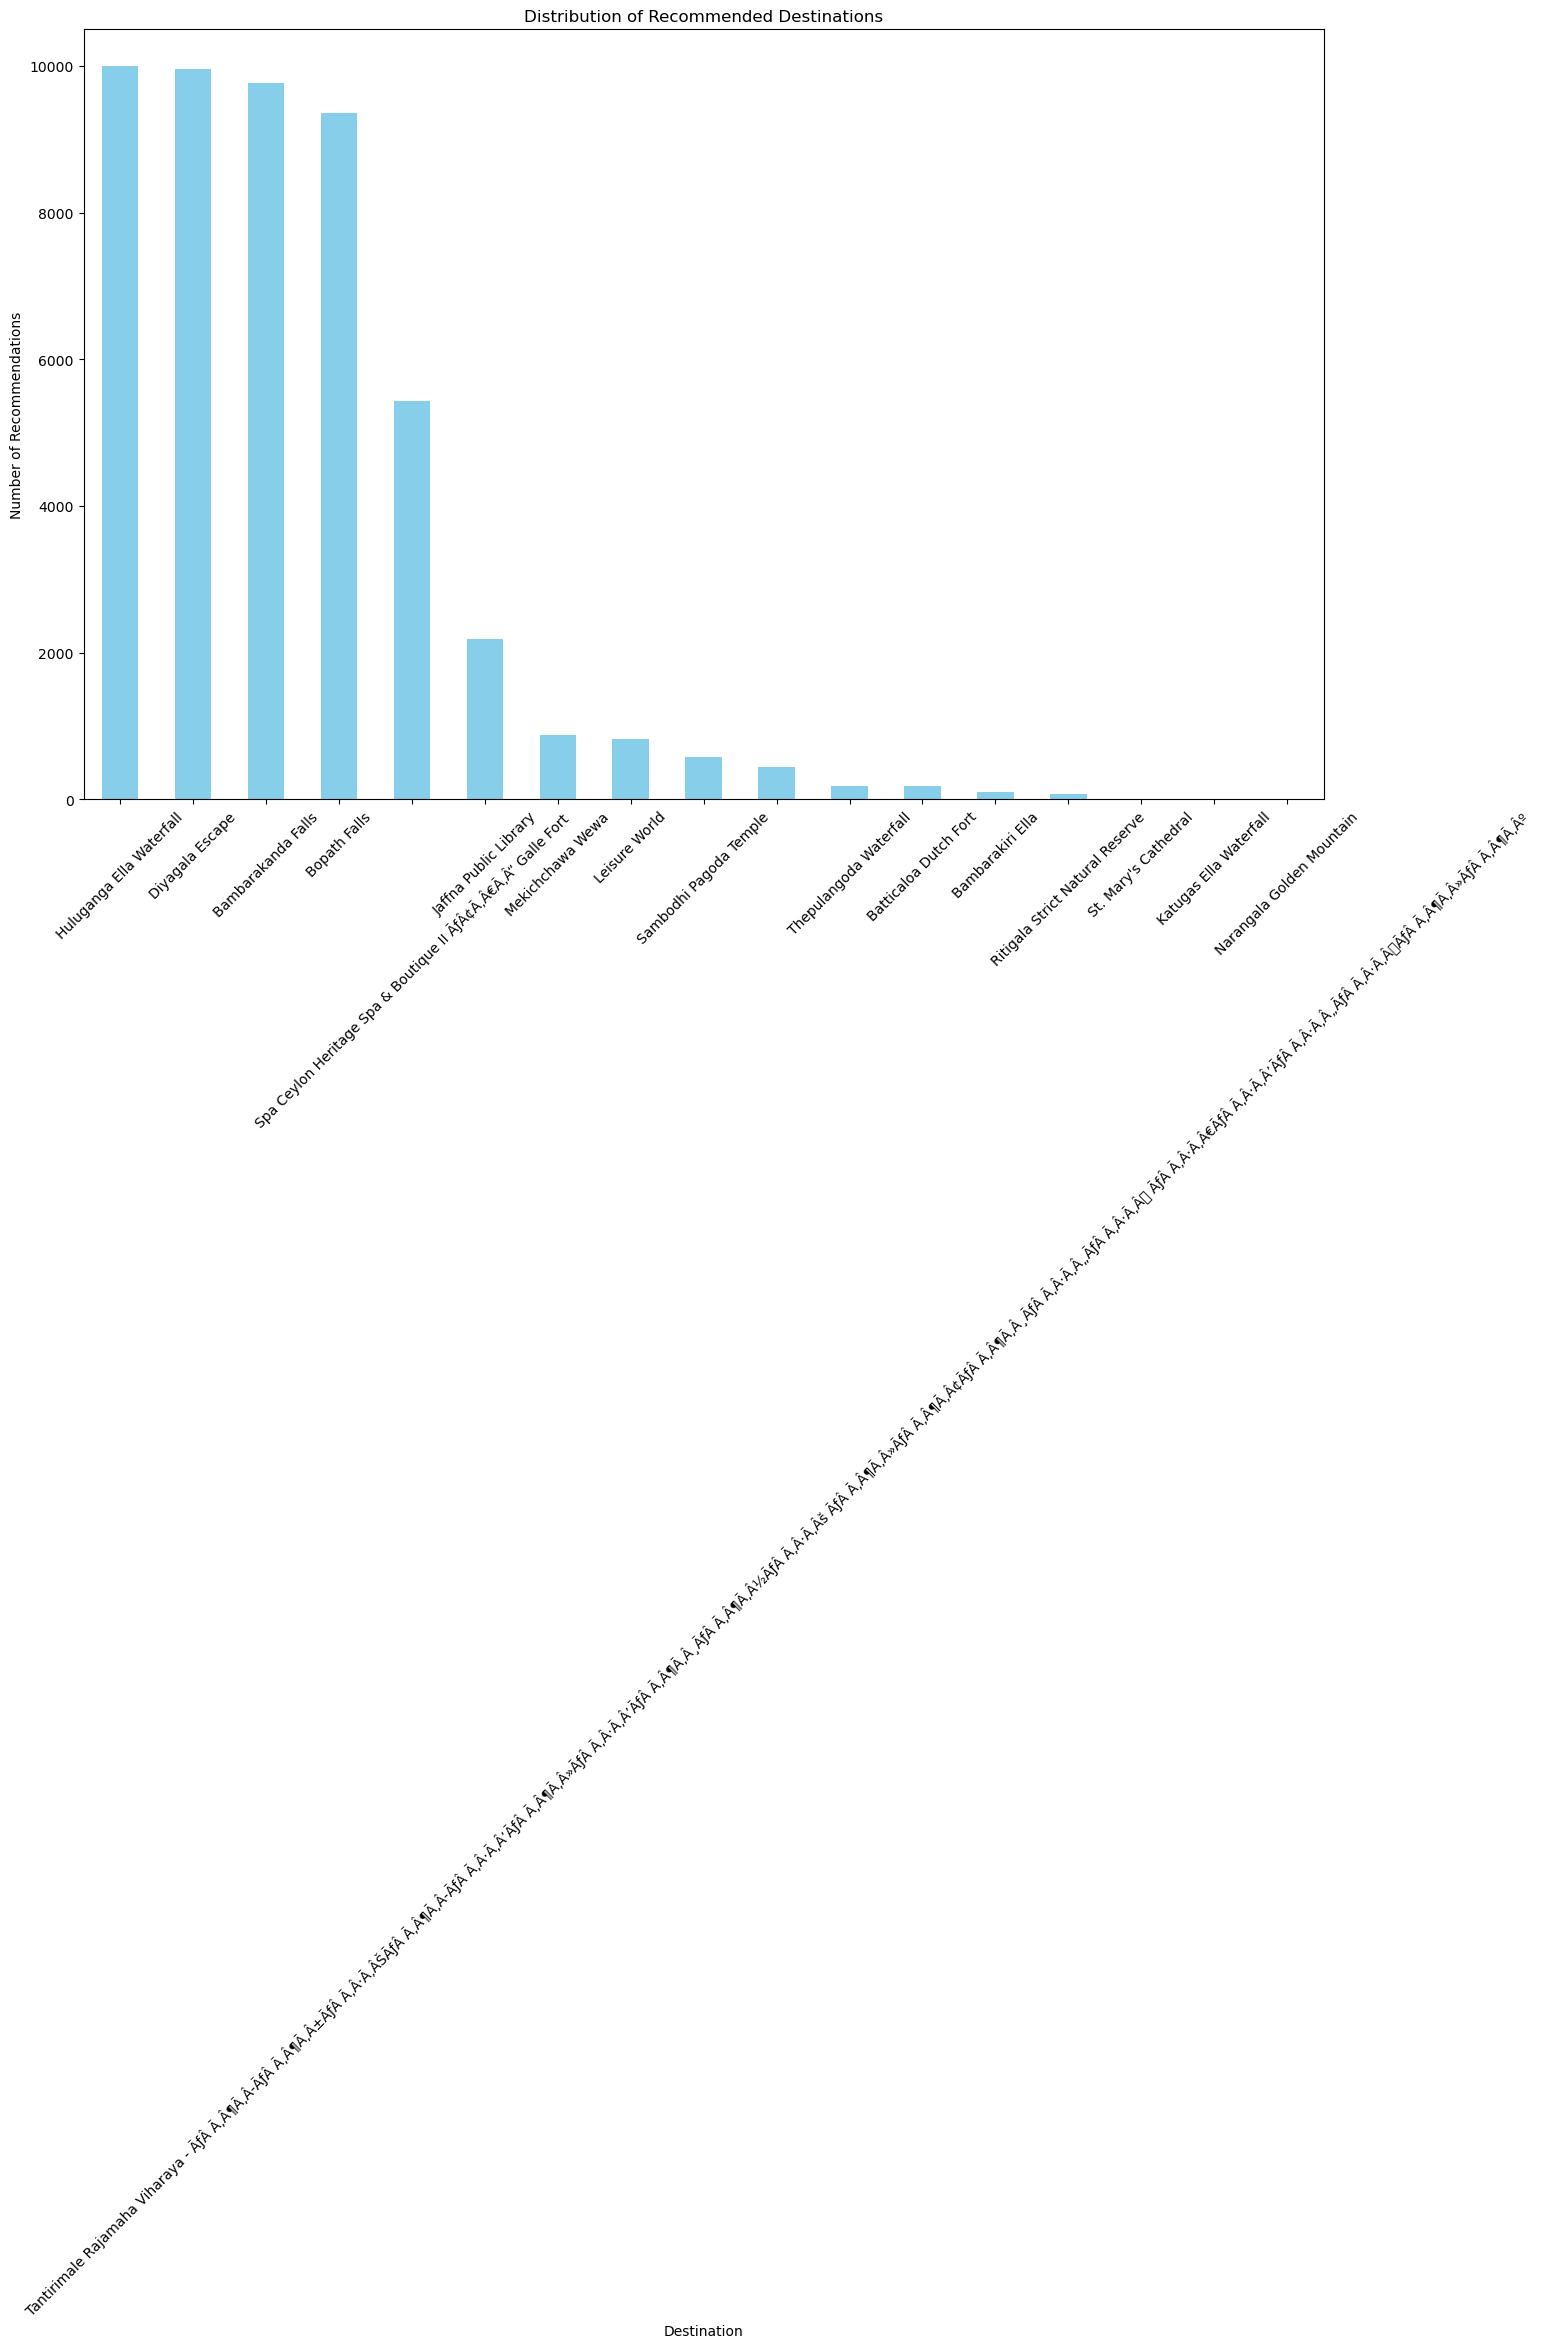

In [98]:
# Create a histogram of the recommendation distribution
plt.figure(figsize=(16, 10))
pd.Series(all_recommendations).value_counts().plot(kind='bar', color='skyblue')

plt.title('Distribution of Recommended Destinations')
plt.xlabel('Destination')
plt.ylabel('Number of Recommendations')
plt.xticks(rotation=45)
plt.show()